# 강화 학습

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
import matplotlib.animation as animation
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices("GPU"):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# 부드러운 애니메이션을 위해

mpl.rc("animation", html="jshtml")

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장 " + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

2023-05-02 06:46:19.214783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 06:46:20.335952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 06:46:20.348373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-02 06:46:20.348611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

## OpenAI 짐

이 노트북은 강화학습 알고리즘을 개발하고 평가하는 훌륭한 도구인 [OpenAI 짐(gym)](https://gym.openai.com/)을 사용한다. 학습 에이전트가 상호작용하기 위한 환경을 많이 제공한다. 먼저 `gym`을 임포트한다:

In [2]:
import gym

가능한 환경 목록을 확인한다:

In [3]:
gym.envs.registry.values()

dict_values([EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0), EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1), EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='MountainCar', version=0), EnvSpec(id='MountainCarContinuous-v0', entry_p

Cart-Pole은 매우 간단한 환경으로 왼쪽과 오른쪽으로 움직이는 카트와 그 위에 수직으로 놓여 있는 막대로 구성된다. 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여 막대가 바로 서 있도록 만들어야 한다.

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

`reset()` 메서드를 호출해 환경을 초기화한다. 이 메서드는 관측을 반환한다:

In [5]:
obs, info = env.reset(seed=42)

관측은 환경에 따라 다르다. 이 경우 4개의 실수로 구성된 1D 넘파이 배열이다. 카트의 수평 위치, 속도, 막대의 각도(0=수직), 각속도를 나타낸다.

In [6]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

환경은 `render()` 메서드를 호출하여 시각화할 수 있다. 그리고 렌더링 모드(환경에 따른 렌더링 옵션)를 선택할 수 있다.

**경고**: (Cart-Pole을 포함해) 일부 환경은 화면 접근 권한이 필요하다. `render_mode="rgb_array"`로 지정하더라도 별도의 윈도우를 연다. 일반적으로 이 윈도우를 무시할 수 있다. 하지만 주피터를 백엔드(headless) 서버로 실행한다면 예외가 발생한다. 이를 피하는 한 가지 방법은 [Xvfb](http://en.wikipedia.org/wiki/Xvfb) 같은 가짜 X 서버를 설치하는 것이다. 데비안이나 우분투에서는 다음과 같이 설치한다:

```bash
$ apt update
$ apt install -y xvfb
```

그다음 `xvfb-run` 명령으로 주피터를 실행한다:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

또는 Xvfb를 감싼 [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) 파이썬 라이브러리를 설치할 수 있다:

```bash
%pip install -U pyvirtualdisplay
```

그다음 다음 코드를 실행한다:

In [7]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [8]:
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

이 예에서는 `render_mode="rgb_array"`로 지정해 환경 이미지를 넘파이 배열로 받는다:

In [9]:
img = env.render()
img.shape

(400, 600, 3)

In [10]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

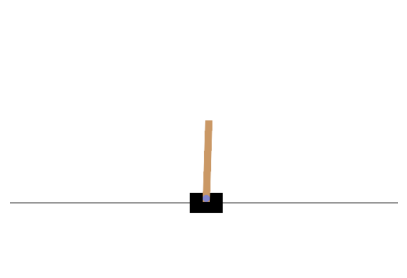

In [11]:
plot_environment(env)
plt.show()

환경과 상호작용하는 방법을 알아 본다. 에이전트는 "행동 공간"(가능한 행동의 집합)에서 하나의 행동을 선택해야 한다. 이 환경의 행동 공간을 다음처럼 확인한다:

In [12]:
env.action_space

Discrete(2)

단 두 개의 행동이 가능하다: 왼쪽 또는 오른쪽으로 가속한다.

막대가 오른쪽으로 기울어져 있기 때문에(`obs[2] > 0`), 카트를 오른쪽으로 가속한다:

In [13]:
action = 1  # 오른쪽으로 가속
obs, reward, terminated, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

이제 카트가 오른쪽으로 움직였다(`obs[1] > 0`). 막대가 여전히 오른쪽으로 기울었다(`obs[2] > 0`). 하지만 각속도가 음수이므로(`obs[3] < 0`) 다음 스텝에서는 왼쪽으로 기울 것이다.

그림 저장 cart_pole_plot


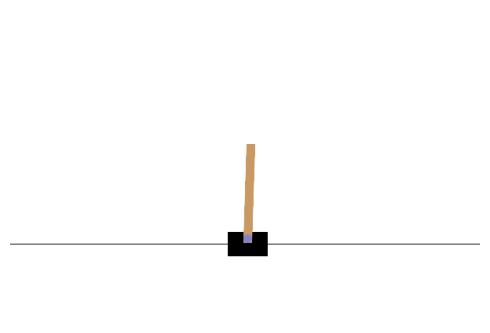

In [14]:
plot_environment(env)
save_fig("cart_pole_plot")

요청한 대로 실행된다!

환경은 이전 스텝에서 얼마나 많은 보상을 받는지 에이전트에게 알린다:

In [15]:
reward

1.0

게임이 끝나면 환경은 `terminated=True`를 반환한다:

In [17]:
terminated

False

마지막으로 `info`는 훈련이나 디버깅에 유용한 추가적인 정보를 담은 환경에 특화된 딕셔너리이다. 예를 들어 일부 게임에서는 얼마나 많은 에이전트의 생명이 몇 개가 남아 있는지 나타낸다.

In [18]:
info

{}

환경이 재설정된 순간부터 종료될 때까지 스텝 시퀀스를 "에피소드"라고 한다. 에피소드 끝에서(즉, `step()`이 `terminated=True`를 반환할 때), 계속하기 전에 환경을 재설정해야 한다.

In [19]:
if terminated:
    obs = env.reset()

그럼 어떻게 막대를 똑바로 유지할 수 있을까? 이를 위해 정책을 정의해야 한다. 에이전트가 매 스텝마다 행동을 선택하기 위해 사용할 전략이다. 어떤 행동을 선택할지 결정하기 위해 지난 행동과 관측을 모두 사용할 수 있다.

**간단한 하드 코딩 정책**